In [1]:
import os
import sys

In [2]:
import time
import subprocess
import numpy as np
import pandas as pd
import cv2
import PIL.Image
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import albumentations
import segmentation_models_pytorch as smp
import timm
from tqdm.notebook import tqdm

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
data_dir = '../xray_image'
model_dir_seg = 'models/'
model_dir_cls = 'models_classification'
num_workers = 2
image_size = 512
batch_size = 8

In [5]:
submission = pd.read_csv(os.path.join(data_dir, 'sample_submission.csv'))

In [6]:
submission.shape

(3582, 12)

In [7]:
class RANZCRDatasetTest(Dataset):

    def __init__(self, df):

        self.df = df.reset_index(drop=True)

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        image = cv2.imread(os.path.join(data_dir, 'test', row.StudyInstanceUID + '.jpg'))[:, :, ::-1]

        #image1024 = cv2.resize(image ,(1024, 1024)).astype(np.float32).transpose(2, 0, 1) / 255.
        image512 = cv2.resize(image ,(512, 512)).astype(np.float32).transpose(2, 0, 1) / 255.

        return torch.tensor(image512)

In [8]:
dataset_test = RANZCRDatasetTest(submission)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

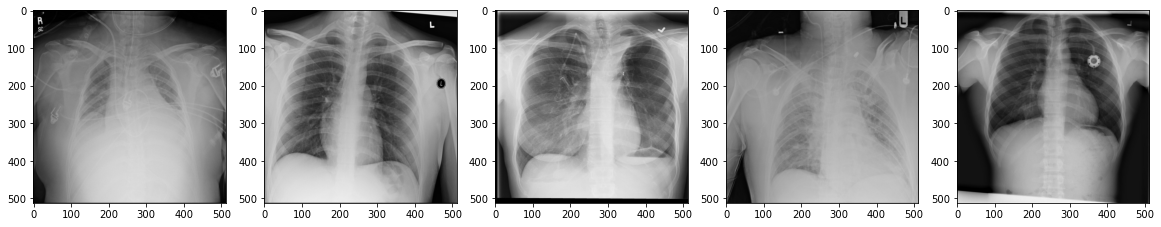

In [9]:
dataset_show = RANZCRDatasetTest(submission)
from pylab import rcParams
rcParams['figure.figsize'] = 20,10

f, axarr = plt.subplots(1,5)

for p in range(5):
    img = dataset_show[p]
    axarr[p].imshow(img.transpose(0, 1).transpose(1,2))

In [10]:
enet_type_seg = 'timm-efficientnet-b1'
kernel_type_seg = 'unet++b1_2cbce_1024T15tip_lr1e4_bs4_augv2_30epo'

enet_type_cls = 'tf_efficientnet_b1_ns'
kernel_type_cls = 'enetb1_5ch_512_lr3e4_bs32_30epo'

In [11]:
class SegModel(nn.Module):
    def __init__(self, backbone):
        super(SegModel, self).__init__()
        self.seg = smp.UnetPlusPlus(encoder_name=backbone, encoder_weights=None, classes=1, activation=None)
    def forward(self,x):
        global_features = self.seg.encoder(x)
        seg_features = self.seg.decoder(*global_features)
        seg_features = self.seg.segmentation_head(seg_features)
        return seg_features
    
class enetv2(nn.Module):
    def __init__(self, enet_type, out_dim):
        super(enetv2, self).__init__()
        self.enet = timm.create_model(enet_type, False)
        self.dropout = nn.Dropout(0.5)
        self.enet.conv_stem.weight = nn.Parameter(self.enet.conv_stem.weight.repeat(1,4//3+1,1,1)[:, :4])
        self.myfc = nn.Linear(self.enet.classifier.in_features, out_dim)
        self.enet.classifier = nn.Identity()

    def extract(self, x):
        return self.enet(x)

    def forward(self, x,mask):
        mask = F.interpolate(mask, x.shape[2])
        x = torch.cat([x, mask], 1)
        x = self.extract(x)
        x = self.myfc(x)
        return x

In [12]:
model_seg = SegModel(enet_type_seg)
model_seg = model_seg.to(device)
model_seg_file = os.path.join(model_dir_seg, f'{kernel_type_seg}_best_epoch16.pth')
model_seg.load_state_dict(torch.load(model_seg_file), strict=True)
model_seg.eval()



model_cls = enetv2(enet_type_cls,12)
model_cls = model_cls.to(device)
model_cls_file = os.path.join(model_dir_cls, f'{kernel_type_cls}_best_fold1.pth')
model_cls.load_state_dict(torch.load(model_cls_file), strict=True)
model_cls.eval()

enetv2(
  (enet): EfficientNet(
    (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (act1): SiLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SiLU(inplace=True)
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act2): Id

In [13]:
PROBS = []
with torch.no_grad():
    for batch_id, data in tqdm(enumerate(test_loader), total=len(test_loader)):
        data = data.to(device)
        mask = model_seg(data).sigmoid()
        logits = model_cls(data, mask)
        logits[:, :4] = logits[:, :4].softmax(1)
        logits[:, 4:] = logits[:, 4:].sigmoid()
        PROBS.append(logits.cpu())
    
PROBS = torch.cat(PROBS, 0)
PROBS = PROBS[:, [0,1,2,4,5,6,7,8,9,10,11]]
PROBS = PROBS.numpy()

  0%|          | 0/448 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

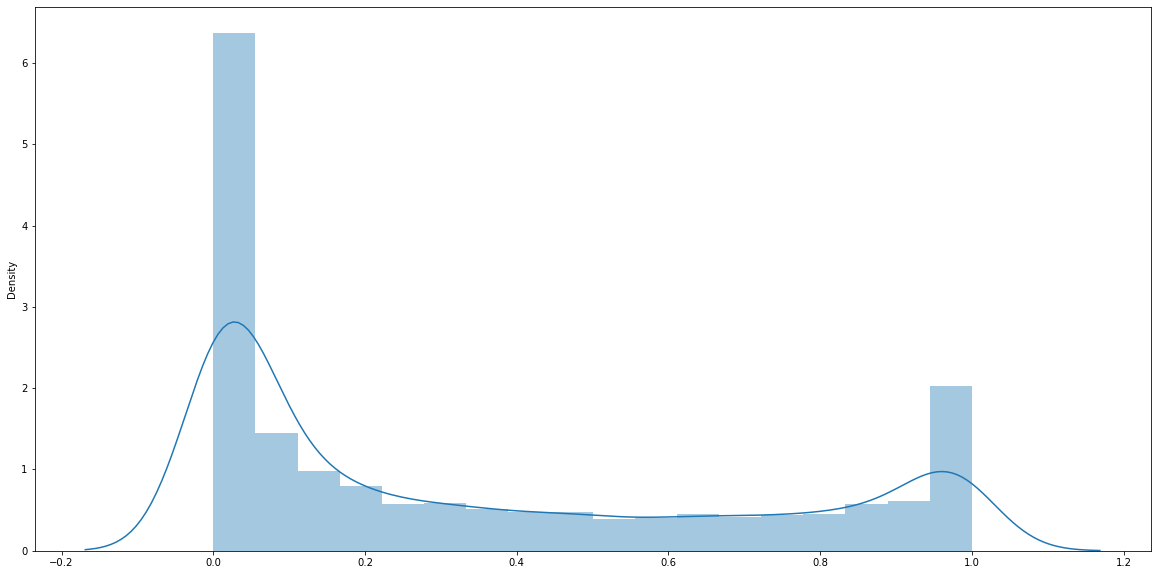

In [14]:
submission[[
    'ETT - Abnormal',
    'ETT - Borderline',
    'ETT - Normal',
    'NGT - Abnormal',
    'NGT - Borderline',
    'NGT - Incompletely Imaged',
    'NGT - Normal',
    'CVC - Abnormal',
    'CVC - Borderline',
    'CVC - Normal',
    'Swan Ganz Catheter Present'
]] = PROBS

sns.distplot(submission[[
    'CVC - Abnormal',
    'CVC - Borderline',
    'CVC - Normal',
]])

In [15]:
submission.to_csv('submission.csv', index=False)

In [16]:
submission.head()

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present
0,1.2.826.0.1.3680043.8.498.46923145579096002617...,0.009056,0.309555,0.680791,0.001252,0.000500,0.009081,0.979541,0.007429,0.028814,0.943273,0.999493
1,1.2.826.0.1.3680043.8.498.84006870182611080091...,0.000002,0.000004,0.000013,0.000081,0.000045,0.000026,0.000076,0.017020,0.005456,0.985095,0.000008
2,1.2.826.0.1.3680043.8.498.12219033294413119947...,0.000009,0.000047,0.000169,0.000405,0.000196,0.000219,0.000155,0.014367,0.485760,0.460907,0.000137
3,1.2.826.0.1.3680043.8.498.84994474380235968109...,0.034404,0.186145,0.373743,0.011644,0.020465,0.945404,0.039643,0.074089,0.080057,0.681798,0.006743
4,1.2.826.0.1.3680043.8.498.35798987793805669662...,0.000002,0.000007,0.000030,0.000105,0.000020,0.000008,0.000031,0.022752,0.217229,0.754902,0.000057
